# Colour - Checker Detection - Examples: Segmentation

This notebook showcases segmentation retated colour checker detection examples.

> Note: The original \*.CR2 files were processed with *dcraw* as follows: `dcraw -T -g 2.4 12.92 *.CR2` and then resized and converted to \*.png.

In [1]:
from __future__ import division

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import OrderedDict

import colour
import colour.plotting

from colour_checker_detection import (
    EXAMPLES_RESOURCES_DIRECTORY,
    colour_checkers_coordinates_segmentation,
    detect_colour_checkers_segmentation)
from colour_checker_detection.detection.segmentation import (
    adjust_image)

plt.style.use(colour.plotting.colour_style())

OETF = colour.RGB_COLOURSPACES['sRGB'].encoding_cctf

EOTF = colour.RGB_COLOURSPACES['sRGB'].decoding_cctf

## Data

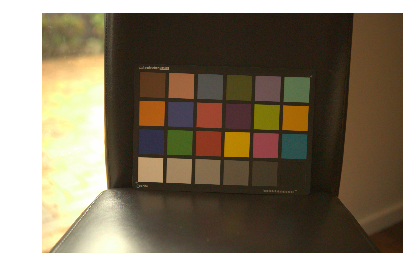

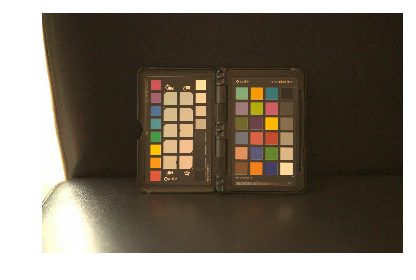

In [2]:
COLOUR_CHECKER_IMAGE_PATHS = glob.glob(
    os.path.join(EXAMPLES_RESOURCES_DIRECTORY, 'detection', '*.png'))

COLOUR_CHECKER_IMAGES = [
    EOTF(colour.io.read_image(path))
    for path in COLOUR_CHECKER_IMAGE_PATHS
]

for image in COLOUR_CHECKER_IMAGES:
    colour.plotting.image_plot(OETF(image))

## Detection

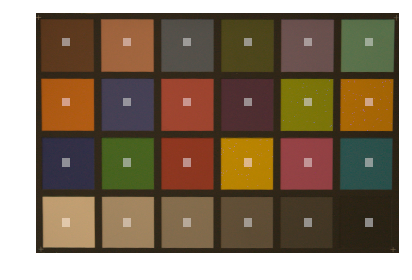

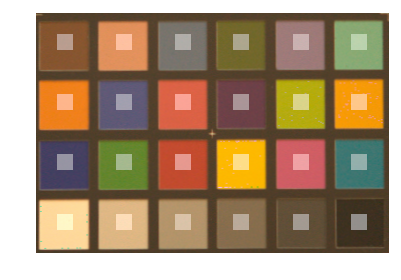

In [3]:
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    for swatches, colour_checker, masks in detect_colour_checkers_segmentation(
        image, additional_data=True):
        SWATCHES.append(swatches)

        # Using the additional data to plot the colour checker and masks.
        masks_i = np.zeros(colour_checker.shape)
        for i, mask in enumerate(masks):
            masks_i[mask[0]:mask[1], mask[2]:mask[3], ...] = 1
        colour.plotting.image_plot(
            OETF(np.clip(colour_checker + masks_i * 0.25, 0, 1)))

## Colour Fitting

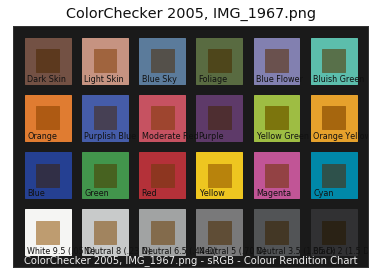

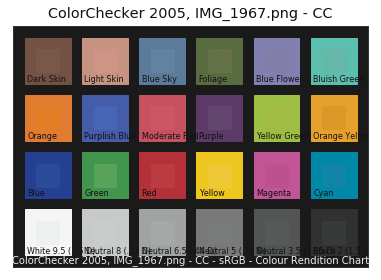

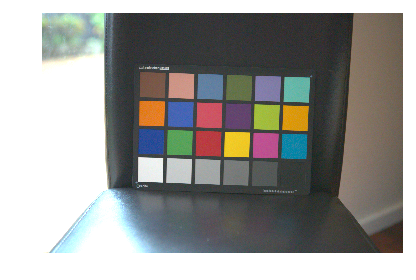

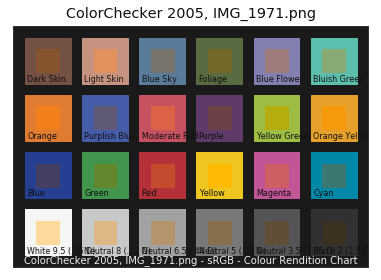

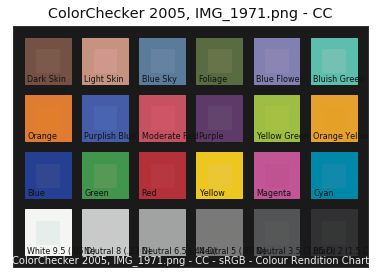

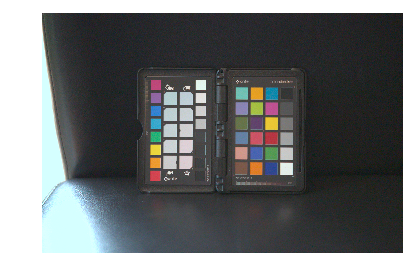

In [4]:
D65 = colour.ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
REFERENCE_COLOUR_CHECKER = colour.COLOURCHECKERS['ColorChecker 2005']

REFERENCE_SWATCHES = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(REFERENCE_COLOUR_CHECKER.data.values()),
        REFERENCE_COLOUR_CHECKER.illuminant, D65,
        colour.RGB_COLOURSPACES['sRGB'].XYZ_to_RGB_matrix)

for i, swatches in enumerate(SWATCHES):
    swatches_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches, D65, D65, colour.RGB_COLOURSPACES['sRGB'].RGB_to_XYZ_matrix))

    colour_checker = colour.characterisation.ColourChecker(
        os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]),
        OrderedDict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_xyY)),
        D65)
    
    colour.plotting.multi_colour_checker_plot(
        [REFERENCE_COLOUR_CHECKER, colour_checker])
    
    swatches_f = colour.colour_correction(swatches, swatches, REFERENCE_SWATCHES)
    swatches_f_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches_f, D65, D65, colour.RGB_COLOURSPACES['sRGB'].RGB_to_XYZ_matrix))
    colour_checker = colour.characterisation.ColourChecker(
        '{0} - CC'.format(os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i])),
        OrderedDict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_f_xyY)),
        D65)
    
    colour.plotting.multi_colour_checker_plot(
        [REFERENCE_COLOUR_CHECKER, colour_checker])

    colour.plotting.image_plot(OETF(
        colour.colour_correction(
            COLOUR_CHECKER_IMAGES[i], swatches, REFERENCE_SWATCHES)))

## Additional Data Plotting

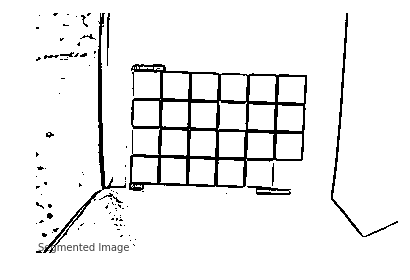

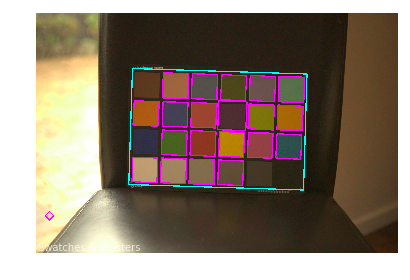

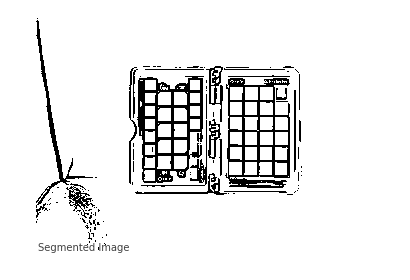

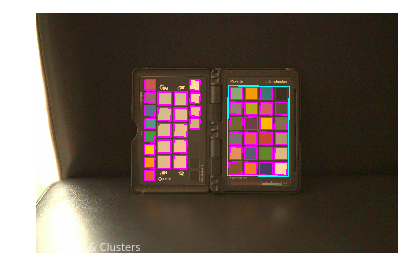

In [5]:
for image in COLOUR_CHECKER_IMAGES:
    colour_checkers, clusters, swatches, segmented_image = (
        colour_checkers_coordinates_segmentation(
            image, additional_data=True))
    
    image_a = adjust_image(image)

    colour.plotting.image_plot(OETF(segmented_image), text_parameters={
        'text': 'Segmented Image',
        'color': 'black'
    })
    
    cv2.drawContours(image_a, swatches, -1, (1, 0, 1), 3)
    cv2.drawContours(image_a, clusters, -1, (0, 1, 1), 3)

    colour.plotting.image_plot(OETF(image_a), text_parameters={
        'text': 'Swatches & Clusters',
        'color': 'white'
    })